In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns       
import pandas as pd                           # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from iminuit.cost import LeastSquares
from scipy import optimize
from scipy.stats import kstest
from scipy.stats import poisson

sys.path.append('../External_Functions')
sys.path.append('../JonathansFunctions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure
from JonathansFunctions import *

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

In [2]:
def read_grip(filename):
	dat = pd.read_csv(filename, sep = '\t', header = None, names = ["sick", "index", "A", "B", "C"]) 
	return dat

fisher = read_grip("data_FisherSyndrome.txt")
sick = fisher["sick"]
index = fisher["index"]
a = fisher["A"]
b = fisher["B"]
c = fisher["C"]

print(fisher)

      sick  index        A        B       C
0        1      0  15.0163  48.5929 -0.4369
1        1      1  15.5746  56.1444 -1.3424
2        1      2   7.2174  36.6392 -0.1413
3        1      3  11.0530  40.0987 -0.1435
4        1      4  14.8968  53.0219 -1.0694
...    ...    ...      ...      ...     ...
4995     0   2995  10.4138  59.2652  0.5668
4996     0   2996  12.9365  66.1804  0.7973
4997     0   2997   5.7978  44.7092  0.3153
4998     0   2998  13.9444  68.1723  0.4751
4999     0   2999  14.0870  61.0854  0.8447

[5000 rows x 5 columns]


In [3]:
N_bins = 100

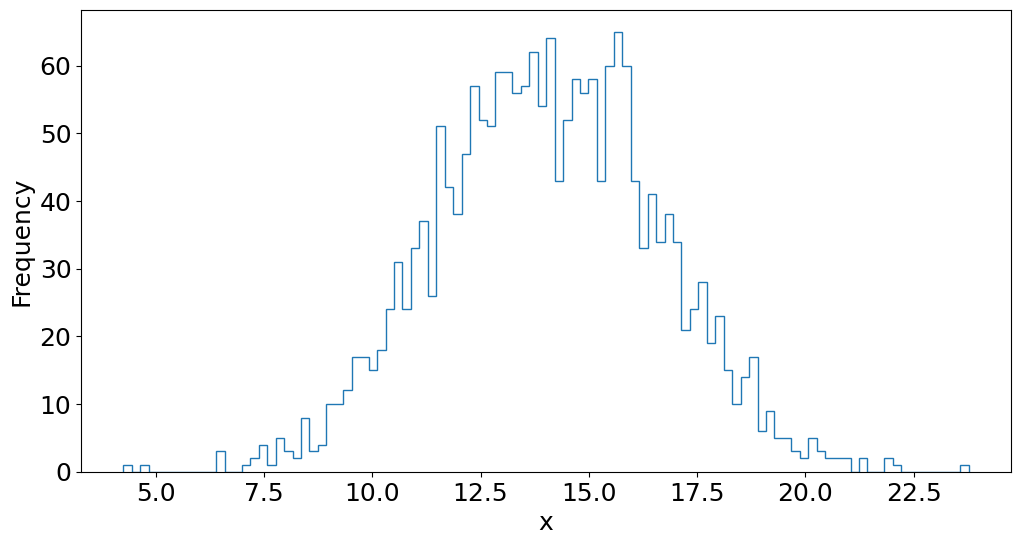

In [4]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.hist(a[sick==1], bins=N_bins, histtype='step', label='histogram' )
ax2.set(xlabel="x", ylabel="Frequency");

In [5]:
def gauss_fit(x,sigma, mu, N):
    return  N*(np.exp(-(x-mu)**2/(2*sigma**2)))/ (sigma*np.sqrt(2*np.pi))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(a[sick==1], bins=50)
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
sy = sy[y>0]
y = y[y>0]

chi2fit = Chi2Regression(gauss_fit, x, y, sy)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

minuit_chi2 = Minuit(chi2fit,sigma=3, mu = 11, N =100)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits

chi2_value = minuit_chi2.fval
N_NotEmptyBin = np.sum(y>0)
Ndof_value = N_NotEmptyBin - len(minuit_chi2.parameters)

minuit_chi2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 30.56                      │              Nfcn = 110              │
│ EDM = 8.19e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ sigma │   2.55    │   0.04    │            │            │         │         │       │
│ 1 │ mu    │   14.05   │   0.06    │            │            │         │         │       │
│ 2 │ N     │    771    │    17     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │    sigma       mu        N │
├───────┼────────────────────────────┤
│ sigma │  0.00189 4.37e-05   0.0168 │
│    mu │ 4.37e-05  0.00342  -0.0001 │
│     N │   0.0168  -0.0001      302 │
└───────┴────────────────────────────┘

In [6]:


fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {minuit_chi2.fval:.1f} / {len(x) - minuit_chi2.nfit}",f"$P-value = {np.round(stats.chi2.sf(chi2_value,Ndof_value),4)}$"]
for p, v, e in zip(minuit_chi2.parameters, minuit_chi2.values, minuit_chi2.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(x,y,sy,fmt ='.', color = 'Black')
ax.hist(a[sick==1], bins=50, histtype='step', label='histogram', color = 'black')
ax.plot(np.linspace(0,25), gauss_fit(np.linspace(0,25),*minuit_chi2.values),label = 'Gaussian Fit', color = 'Red')
ax.set_xlim(0,25)
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));


TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

In [7]:
cov = np.mean(b[sick==1]*c[sick==1])-np.mean(b[sick==1])*np.mean(c[sick==1])

correlation = cov/(np.std(b[sick==1])*np.std(c[sick==1]))

print(cov, correlation)

-1.3505507744087044 -0.3882711452946683


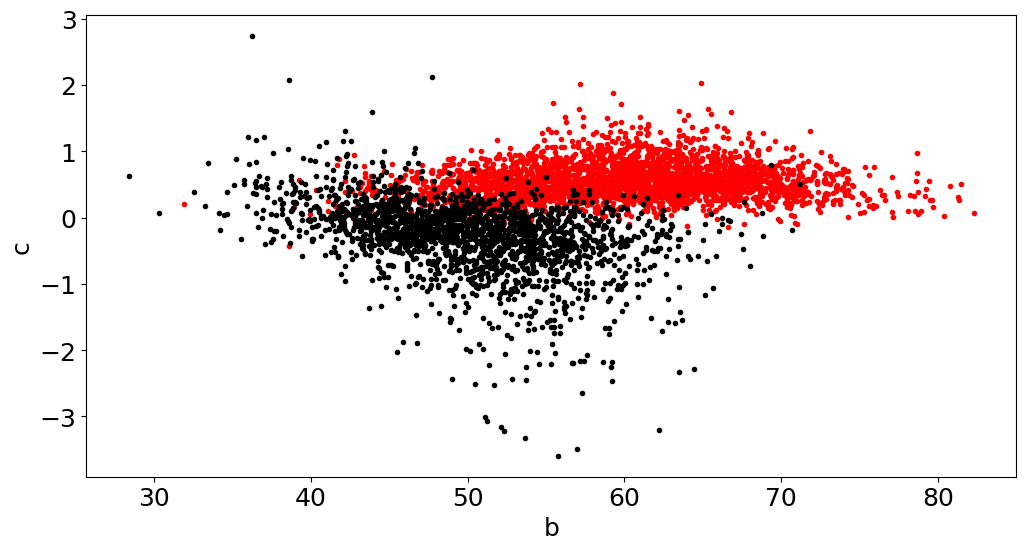

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(b[sick==0],c[sick==0],'.', color = 'red')
ax.plot(b[sick==1],c[sick==1],'.', color = 'Black')
ax.set(xlabel="b", ylabel="c");



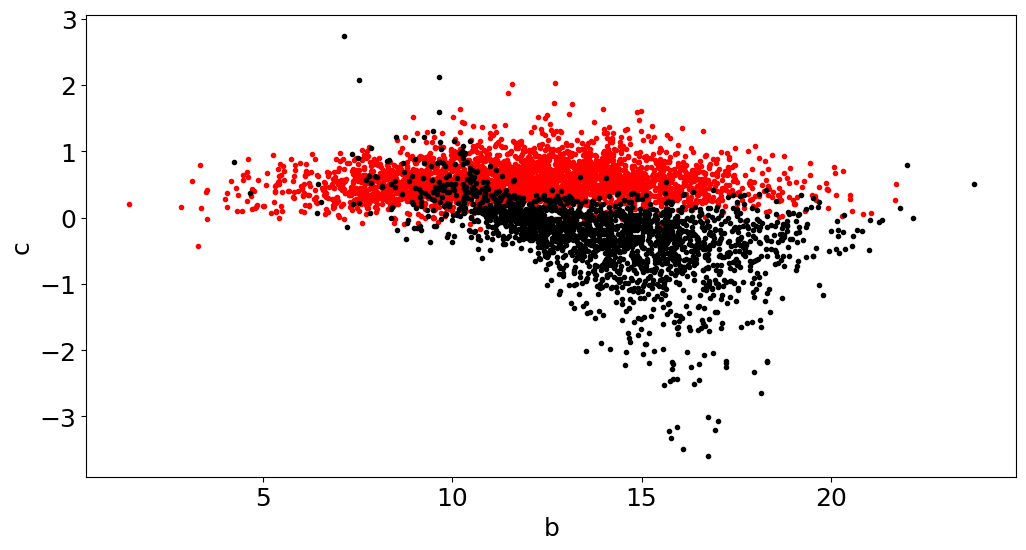

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(a[sick==0],c[sick==0],'.', color = 'red')
ax.plot(a[sick==1],c[sick==1],'.', color = 'Black')
ax.set(xlabel="b", ylabel="c");

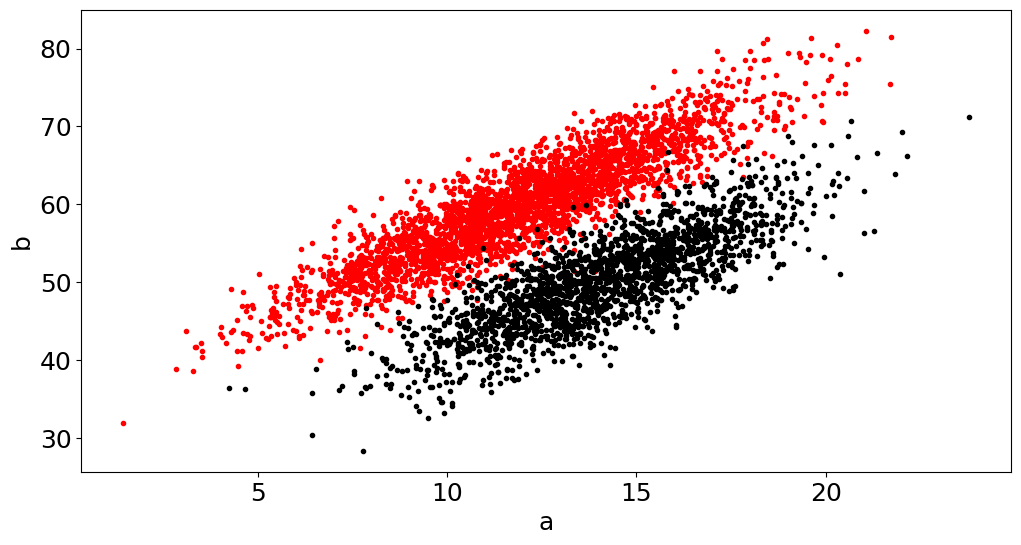

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(a[sick==0],b[sick==0],'.', color = 'red')
ax.plot(a[sick==1],b[sick==1],'.', color = 'Black')
ax.set(xlabel="a", ylabel="b");

In [22]:
#From the plots we can see that separating the data according the the A and B category with a fisher projection can work.
#F = w0 + w•x
#w = sum(covariance matrix healthy and covariance matrix sick)^-1*(meanhealthy-meansick)
s_cov_AB = np.mean(b[sick==1]*a[sick==1])-np.mean(b[sick==1])*np.mean(a[sick==1])
s_cov_AA = np.mean(a[sick==1]*a[sick==1])-np.mean(a[sick==1])*np.mean(a[sick==1])
s_cov_BB = np.mean(b[sick==1]*b[sick==1])-np.mean(b[sick==1])*np.mean(b[sick==1])

h_cov_AB = np.mean(b[sick==0]*a[sick==0])-np.mean(b[sick==0])*np.mean(a[sick==0])
h_cov_AA = np.mean(a[sick==0]*a[sick==0])-np.mean(a[sick==0])*np.mean(a[sick==0])
h_cov_BB = np.mean(b[sick==0]*b[sick==0])-np.mean(b[sick==0])*np.mean(b[sick==0])

#make the matrices with covariance
M_S = np.array([[s_cov_AA, s_cov_AB],[s_cov_AB, s_cov_BB]])
H_S = np.array([[h_cov_AA, h_cov_AB],[h_cov_AB, h_cov_BB]])

#make the mean difference vector
s_mA = np.mean(a[sick==1])
s_mB = np.mean(b[sick==1])
h_mA = np.mean(a[sick==0])
h_mB = np.mean(b[sick==0])
#mean_vector = np.array([s_mA - h_mA, s_mB - h_mB])
mean_vector = np.array([h_mA - s_mA, h_mB - s_mB])

matrix_in = np.linalg.inv(M_S+H_S)
print(f"m_inv {matrix_in.shape}") 
print(f"mean_vector {mean_vector}")
weights = matrix_in.dot(mean_vector)
print(f"weights {weights.shape}")

data_merge = np.asmatrix([a[sick==1],b[sick==1]]) #Only sick data
print(f"data {data_merge.shape}")

F = np.array(weights.T.dot(data_merge)) 
F2 = F[0,:] #this is just because the format i got out for F cannot be plotted in a histogram
print(F2.shape)

data_merge_h = np.asmatrix([a[sick==0],b[sick==0]]) #only healthy data
Fh = np.array(weights.T.dot(data_merge_h))
F2h = Fh[0,:]

m_inv (2, 2)
mean_vector [-2.08167223  9.7131244 ]
weights (2,)
data (2, 2000)
(2000,)


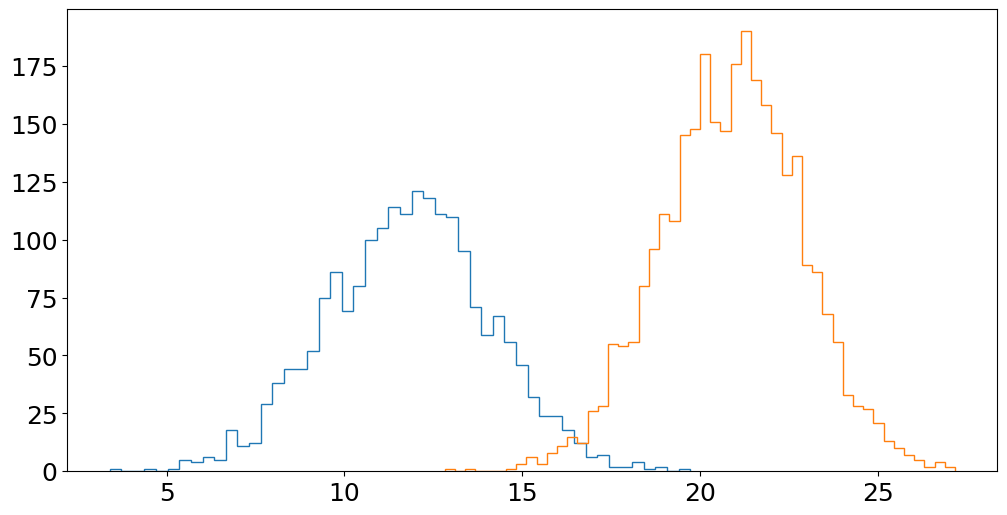

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(F2, bins=50, histtype='step', label='I');
ax.hist(F2h, bins=50, histtype='step', label='I');

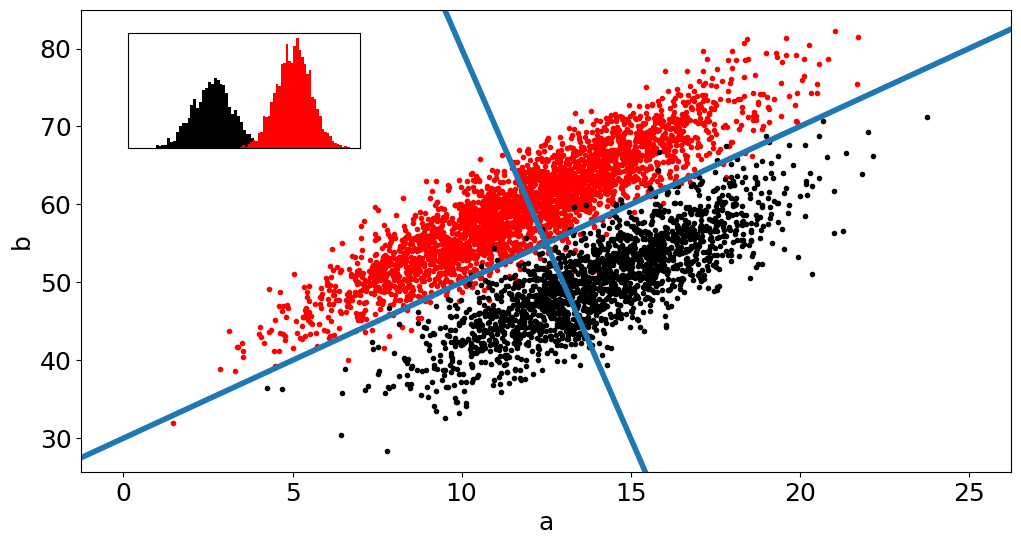

In [63]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(a[sick==0],b[sick==0],'.', color = 'red')
ax.plot(a[sick==1],b[sick==1],'.', color = 'Black')
ax.axline((0,30),(25,80), linewidth= 4)
ax.axline((10,80),(15,30), linewidth= 4)
ax.set(xlabel="a", ylabel="b");

ax2 = ax.inset_axes([0.05, 0.7, 0.25, 0.25])
ax2.hist(F2, bins=50, color ='black')
ax2.hist(F2h, bins=50, color ='red');
yticks = ax2.yaxis.get_major_ticks()
yticks[0].set_visible(False)
yticks[1].set_visible(False)
yticks[2].set_visible(False)
xticks = ax2.xaxis.get_major_ticks()
xticks[0].set_visible(False)
xticks[1].set_visible(False)
xticks[2].set_visible(False)